In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

import dataset
import rendering
import model
import train

import mcubes
import trimesh

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tn = 8.
tf = 12.

nerf_model = torch.load('../models/model_nerf').to(device)
nerf_model

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=257, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Si

### Ray Marching
- code the ray marching algo
- takes the grid of density, 
- based on the density, the algo knows where there is density and where there is not.
- based that creates the mesh

In [3]:
N = 100
scale = 1.5
x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)
print(f"x: {x}")
print(f"x.shape: {x.shape}")

#3d grid values
x, y, z = torch.meshgrid((x, y, z))
print(f"x: {x}")
print(f"x mesh grid shape: {x.shape}")

x: tensor([-1.5000, -1.4697, -1.4394, -1.4091, -1.3788, -1.3485, -1.3182, -1.2879,
        -1.2576, -1.2273, -1.1970, -1.1667, -1.1364, -1.1061, -1.0758, -1.0455,
        -1.0152, -0.9848, -0.9545, -0.9242, -0.8939, -0.8636, -0.8333, -0.8030,
        -0.7727, -0.7424, -0.7121, -0.6818, -0.6515, -0.6212, -0.5909, -0.5606,
        -0.5303, -0.5000, -0.4697, -0.4394, -0.4091, -0.3788, -0.3485, -0.3182,
        -0.2879, -0.2576, -0.2273, -0.1970, -0.1667, -0.1364, -0.1061, -0.0758,
        -0.0455, -0.0152,  0.0152,  0.0455,  0.0758,  0.1061,  0.1364,  0.1667,
         0.1970,  0.2273,  0.2576,  0.2879,  0.3182,  0.3485,  0.3788,  0.4091,
         0.4394,  0.4697,  0.5000,  0.5303,  0.5606,  0.5909,  0.6212,  0.6515,
         0.6818,  0.7121,  0.7424,  0.7727,  0.8030,  0.8333,  0.8636,  0.8939,
         0.9242,  0.9545,  0.9848,  1.0152,  1.0455,  1.0758,  1.1061,  1.1364,
         1.1667,  1.1970,  1.2273,  1.2576,  1.2879,  1.3182,  1.3485,  1.3788,
         1.4091,  1.4394,  1.4697,  1

/home/stanley/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
z

tensor([[[-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         ...,
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000]],

        [[-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         ...,
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000]],

        [[-1.5000, -1.4697, -1.4394,  ...,  1.4394,  1.4697,  1.5000],
         [-1.5000, -1.4697, -1.4394,  ...,  1

In [5]:
xyz = torch.cat((x.reshape(-1,1),
                 y.reshape(-1,1),
                 z.reshape(-1,1)), dim=1)
print(f"xyz shape: {xyz.shape}")

xyz shape: torch.Size([1000000, 3])


as well can see we have a voxel with 1Million values, we will query the nerf model to know what the density is at that posiiton.

In [6]:
with torch.inference_mode():
    _, density = nerf_model.forward(xyz.to(device),
                               torch.zeros_like(xyz).to(device))
    
print(f"densit.shape: {density.shape}")
density = density.cpu().numpy().reshape(N, N, N)
print(f"New density shape: {density.shape}")


densit.shape: torch.Size([1000000])
New density shape: (100, 100, 100)


### now that we have the density 
- we will use the ray marching to get mesh from the density

In [7]:
vertices, triangles = mcubes.marching_cubes(density, 10 * np.mean(density)) #np.mean(desnity) is the threshold parameter multiply it by a scalar value
vertices.dtype, vertices.shape,vertices, triangles.dtype, triangles.shape, triangles

(dtype('float64'),
 (8422, 3),
 array([[31.98583589, 84.        , 46.        ],
        [32.        , 83.95650465, 46.        ],
        [32.        , 84.        , 45.98583589],
        ...,
        [87.92030871, 37.        , 49.        ],
        [87.92599447, 37.        , 50.        ],
        [87.43421566, 37.        , 51.        ]]),
 dtype('uint64'),
 (16832, 3),
 array([[   2,    1,    0],
        [   1,    4,    3],
        [   0,    1,    3],
        ...,
        [8421, 8420, 8410],
        [8412, 8421, 8410],
        [8421, 8412, 8405]], dtype=uint64))

as you can see we have 20728 triangles with 3 vertices, instead of representing the values of the veritcies directly we are just giving points to the verticies via the triangles

In [8]:
print(f"First Triangle: {triangles[0]}")
print(f"Vertex 2: {vertices[2]}")
print(f"Vertex 1: {vertices[1]}")
print(f"Vertex 0: {vertices[0]}")
print("these are the coords of the coordinates of hte first triangle\n")


print(f"second Triangle: {triangles[1]}")
print(f"Vertex 2: {vertices[1]}")
print(f"Vertex 1: {vertices[3]}")
print(f"Vertex 0: {vertices[0]}")
print("these are the coords of the coordinates of hte second triangle")

First Triangle: [2 1 0]
Vertex 2: [32.         84.         45.98583589]
Vertex 1: [32.         83.95650465 46.        ]
Vertex 0: [31.98583589 84.         46.        ]
these are the coords of the coordinates of hte first triangle

second Triangle: [1 4 3]
Vertex 2: [32.         83.95650465 46.        ]
Vertex 1: [31.34104651 84.         47.        ]
Vertex 0: [31.98583589 84.         46.        ]
these are the coords of the coordinates of hte second triangle


### the First triangle contains vertexes (v2, v1, v0) as seen above
-  the coordinates of the vertices in 3D is given by the list of vertices shaped [10446, 3]

### Our mesh is made of triangle.shape[0] = 20728 triangles and vertices.shape[0] = 10446 vertices
- this is how it is represented in modern ray tracing programs 
- memory efficient 
- using vertices as point values to triangle coords
- as there are multiple vertices that are shared btw multiple triangles.

In [9]:
mesh = trimesh.Trimesh(vertices / N, triangles) #coors go from -1 to 1 the `/ N ` is not neccesary
mesh.show()

In [10]:
print(f"mean desnity threshold : {np.mean(density)}")

mean desnity threshold : 0.4580818712711334


we used np.mean(density) above as the threshold parameters
- even tho the target has zero density in empty space
- the nerf model doesnt return exactly zero density
- therefore we use the mean as a threshold where density below that are not considered

`note:` increase the threshold to filter undesirable noise caused due to lower density predictions

We can easier save the extracted mesh and load in `blender` or `unity`

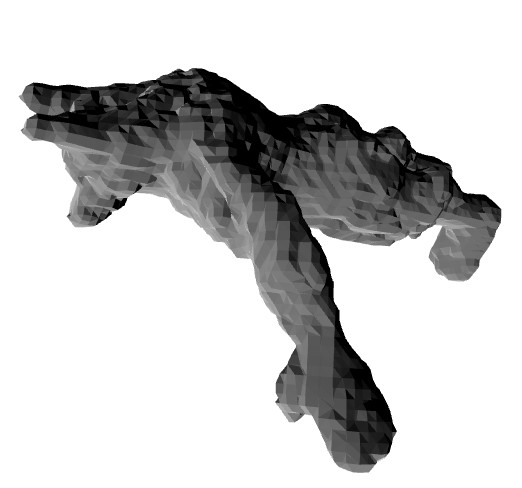

## Color Extraction

### NeRF models are not that good at representing meshes they are dedicated to novel view synthesis
- even tho its better than most 3D rep tools present in 2020 before the paper
- nERF is based on volumetric represnetation of the scene, mesh is not very well defined
- Neural Surface representation has much better mesh output
- meshes can be plugged into any software
- there are newer papers with cover better methods

### Mesh Normal
- for each triangle in the mesh, we have a normal vector

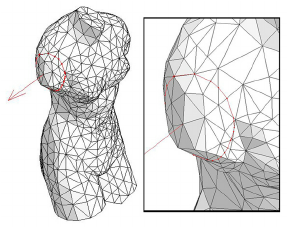

### Color Extraction of each triangles from normals
- go in the dir. of the normal, at distance t from the normal put a camera.
- shoot a ray in the opposite dir. of the normal therefore the ray hits the point in the mesh
- then ask NeRF model, what is the color of the ray
therefore we get color of the ray that ill touch the mesh at this exact location therefore we'll know the color of the triangle,
- repeat for all triangles to get color of the entire tri-mesh

`note:` this method is prone to errors due to occlusion, ie we get the color of the triangle that obstructs the ray first

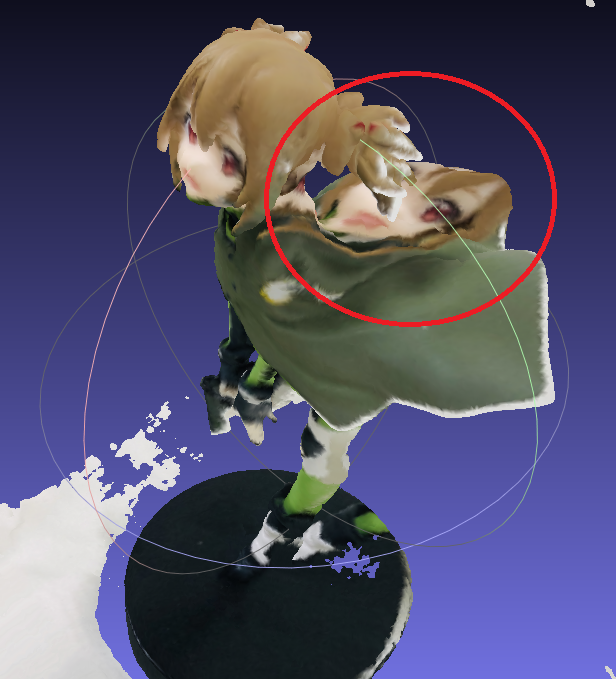

reference from : https://github.com/kwea123/nerf_pl/blob/master/README_mesh.md

- check out step 4. mentions:

    "We adopt the concept of assigning colors to vertices instead of faces (they are actually somehow equivalent, as you can think of the color of vertices as the average color of neighboring faces and vice versa).To compute the color of a vertex, we leverage the training images: we project this vertex onto the training images to get its rgb values, then average these values as its final color. Notice that the projected pixel coordinates are floating numbers, and we use bilinear interpolation as its rgb value."
    



### in order for the mesh to match the coords of the world coords we can invert the x and y coords, 

```py
    x_ = (ymax-ymin) * vertices_[:, 1] + ymin
    y_ = (xmax-xmin) * vertices_[:, 0] + xmin
    vertices_[:, 0] = x_
    vertices_[:, 1] = y_
    vertices_[:, 2] = (zmax-zmin) * vertices_[:, 2] + zmin
    vertices_.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4')]

    face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
    face['vertex_indices'] = triangles
```
#### `note:` only for o3d lib: saving the verticies and triangles extracted only for o3d library *.ply so it be opened in open3d library
```py
    PlyData([PlyElement.describe(vertices_[:, 0], 'vertex'), 
             PlyElement.describe(face, 'face')]).write(f'{args.scene_name}.ply')
             
```

### in order to remove the extra noise eg. from below the feet using biggest clusters
```py

    # remove noise in the mesh by keeping only the biggest cluster
    print('Removing noise ...')
    mesh = o3d.io.read_triangle_mesh(f"{args.scene_name}.ply")
    idxs, count, _ = mesh.cluster_connected_triangles()
    max_cluster_idx = np.argmax(count)
    triangles_to_remove = [i for i in range(len(face)) if idxs[i] != max_cluster_idx]
    mesh.remove_triangles_by_index(triangles_to_remove)
    mesh.remove_unreferenced_vertices()
    print(f'Mesh has {len(mesh.vertices)/1e6:.2f} M vertices and {len(mesh.triangles)/1e6:.2f} M faces.')

    vertices_ = np.asarray(mesh.vertices).astype(np.float32)
    triangles = np.asarray(mesh.triangles)
```

### we have 2 methods
1. using vertex normals and nerf model. as seen above
2. 

### method 2 removes self-occlusion

In [ ]:
mesh.vertex_normals